In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from datetime import timedelta

df = pd.read_csv("/content/train.csv")
df = df[['Order Date', 'Sales']]

df = df.groupby('Order Date').sum().asfreq('D').fillna(0)

scaler = MinMaxScaler()
scaled_sales = scaler.fit_transform(df[['Sales']])

window = 30
X, y = [], []
for i in range(len(scaled_sales) - window):
    X.append(scaled_sales[i:i+window])
    y.append(scaled_sales[i+window])
X, y = np.array(X), np.array(y)


,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales
0,1,CA-2017-152156,08/11/2017,11/11/2017,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600
1,2,CA-2017-152156,08/11/2017,11/11/2017,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400
2,3,CA-2017-138688,12/06/2017,16/06/2017,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,California,90036.0,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200
3,4,US-2016-108966,11/10/2016,18/10/2016,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311.0,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775
4,5,US-2016-108966,11/10/2016,18/10/2016,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311.0,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9795,9796,CA-2017-125920,21/05/2017,28/05/2017,Standard Class,SH-19975,Sally Hughsby,Corporate,United States,Chicago,Illinois,60610.0,Central,OFF-BI-10003429,Office Supplies,Binders,"Cardinal HOLDit! Binder Insert Strips,Extra St...",3.7980
9796,9797,CA-2016-128608,12/01/2016,17/01/2016,Standard Class,CS-12490,Cindy Schnelling,Corporate,United States,Toledo,Ohio,43615.0,East,OFF-AR-10001374,Office Supplies,Art,"BIC Brite Liner Highlighters, Chisel Tip",10.3680
9797,9798,CA-2016-128608,12/01/2016,17/01/2016,Standard Class,CS-12490,Cindy Schnelling,Corporate,United States,Toledo,Ohio,43615.0,East,TEC-PH-10004977,Technology,Phones,GE 30524EE4,235.1880
9798,9799,CA-2016-128608,12/01/2016,17/01/2016,Standard Class,CS-12490,Cindy Schnelling,Corporate,United States,Toledo,Ohio,43615.0,East,TEC-PH-10000912,Technology,Phones,Anker 24W Portable Micro USB Car Charger,26.3760


In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from datetime import timedelta
df = pd.read_csv("/content/train.csv")
df['Order Date'] = pd.to_datetime(df['Order Date'], dayfirst=True)

df = df[['Order Date', 'Sales']]

df = df.groupby('Order Date').sum().asfreq('D', fill_value=0)

scaler = MinMaxScaler()
scaled_sales = scaler.fit_transform(df[['Sales']])

In [15]:
window = 30
X, y = [], []
for i in range(len(scaled_sales) - window):
    X.append(scaled_sales[i:i+window])
    y.append(scaled_sales[i+window])
X, y = np.array(X), np.array(y)

model = Sequential([
    LSTM(50, activation='relu', input_shape=(window, 1)),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')
model.fit(X, y, epochs=20, batch_size=16, verbose=0)

last_sequence = scaled_sales[-window:]
future_predictions = []
for _ in range(7):
    input_seq = last_sequence.reshape(1, window, 1)
    pred = model.predict(input_seq, verbose=0)[0][0]
    future_predictions.append(pred)
    last_sequence = np.append(last_sequence[1:], [[pred]], axis=0)

predicted_sales = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1)).flatten()

last_date = df.index[-1]
forecast_dates = [last_date + timedelta(days=i) for i in range(1, 8)]

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


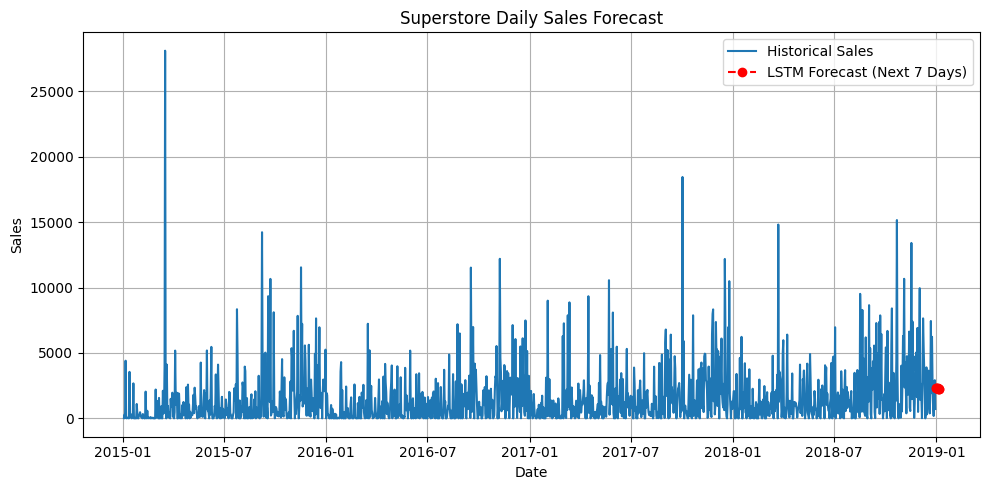

In [16]:
plt.figure(figsize=(10, 5))
plt.plot(df.index, df['Sales'], label='Historical Sales')
plt.plot(forecast_dates, predicted_sales, 'ro--', label='LSTM Forecast (Next 7 Days)')
plt.title("Superstore Daily Sales Forecast")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()